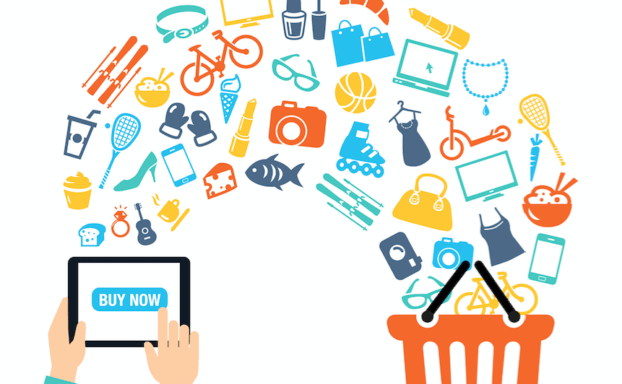

https://ieltspracticeonline.com/wp-content/uploads/2020/08/ielts-speaking-part-3-online-retail-bussinesses.png

### İş Problemi


Bir e-ticaret firması müşretilerini segmentlere ayırarak pazarlama stratejileri belirlenmesi ve gelir artışı hedeflenmektedir. Firma için çok kazançlı olan müşterileri elde tutmak için farklı kampanyalar, yeni müşteriler için farklı kampanyalar düzenlemek istemektedir. 



### Veri Seti Hikayesi

Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlardan oluşmaktadır. Ürün kataloğunda hediyelik eşyalar yer almaktadır. 

https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

### Değişkenler

**Invoice**   : Fatura Numarası. Eğer bu kod C ile başlıyor ise işlemin iptal edildiğini gösterir.

**StockCode**   : Ürün Kodu. Her bir ürün için eşsiz numara.

**Description** : Ürün ismi

**Quantity**    : Satılan ürün adedi

**InvoiceDate** : Fatura tarihi

**Price**   : Fatura fiyatı(Sterlin)

**CustomerID**  : Eşsiz müşteri numarası

**Country**     : Ülke ismi




In [ ]:
#!pip install openpyxl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

### Veri Hazırlama ve Ön İşleme 

In [ ]:
# Veri setinin okutulması 
df_ = pd.read_csv("../input/online-retail-ii-uci/online_retail_II.csv")
df = df_.copy()
df.head()

In [ ]:
df.shape

In [ ]:
# Toplam satın alma kazancı için "TotalPrice" değişkeni oluşturma
df["TotalPrice"] = df["Quantity"] * df["Price"] 

In [ ]:
#Eksik gözlemlerin incelenmesi
df.isnull().sum()

In [ ]:
# Eksik gözlemler veri setinden kalıcı olarak çıkarılması
df.dropna(inplace = True) 

In [ ]:
df.shape


In [ ]:
# Toplam ürün kodu
df["StockCode"].nunique()

In [ ]:
df.describe().T

In [ ]:
#Faturalarda iadeler olduğu için Quantity ve Price değişkenlerinde negatif değerler mevcuttur. İadeler veri setinden çıkarıldı.
df = df[~df["Invoice"].str.contains("C", na=False)]
df.shape

### RFM Metriklerinin Hesaplanması 

* Recency(Yenilik)        : Müşterinin son satın almasından bugüne kadar geçen süre. 

* Frequency(Sıklık)       : Toplam satın alma sayısı.

* Monetary(Parasal Değer) : Müşterinin yaptığı toplam harcama.


In [ ]:
df["InvoiceDate"].max()


In [ ]:
# En son alışveriş yapılan tarihe 2 gün eklenerek analiz tarihi belirlendi. 
today_date = dt.datetime(2011, 12, 11)
today_date

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

**Veri seti Customer ID değişkenine göre gruplanmış ve RFM metrikleri hesaplanmıştır.**
* Recency değeri için analiz tarihi ve müşterinin en son alışveriş yaptığı tarihin gün olarak farkıdır. Bu hesaplama için InvoiceDate değişkeni kullanıldı.
* Frequency değeri için  müşterinin yaptığı toplam alışveriş sayısı alındı.Bu hesaplama için Invoice değişkeni kullanıldı.
* Monetary değeri müşterinin toplam harcama tutarıdır. Bu hesaplama için TotalPrice değişkeninin toplamı alındı.

In [ ]:

rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                     'Invoice': lambda num: num.nunique(),
                                     'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [ ]:
rfm.columns = ["Recency", "Frequency", "Monetary"]


In [ ]:
rfm.head()

#### Recency Ve Frequency Değerleri İçin Saçılım Grafiği

In [ ]:
plt.scatter(rfm['Recency'], rfm['Frequency'],
            color = 'orchid',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Recency and Frequency')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.show()

#### Monetary Ve Frequency Değerleri İçin Saçılım Grafiği

In [ ]:
plt.scatter(rfm['Monetary'], rfm['Frequency'],
            color = 'orchid',
            marker = '*', alpha = 0.3)

plt.title('Scatter Plot for Monetary and Frequency')
plt.xlabel('Monetary')
plt.ylabel('Frequency')
plt.show()

#### RFM Skorları

In [ ]:
#Recency skorunda en yakın tarih 1 , en uzak tarih 5 değerini alır.
rfm["Recency_Score"] = pd.qcut(rfm["Recency"], 5, labels=[5,4,3,2,1]) 

#Frequency skorunda en az sıklık 1 , en fazla sıklık 5 değerini alır. 
rfm["Frequency_Score"] = pd.qcut(rfm["Frequency"].rank(method = "first"),5 ,labels=[1,2,3,4,5]) 

#Monetary skorunda en az para 1, en fazla para 5 değerini alır.
rfm["Monetary_Score"] = pd.qcut(rfm["Monetary"], 5, labels=[1,2,3,4,5]) 

rfm.head()

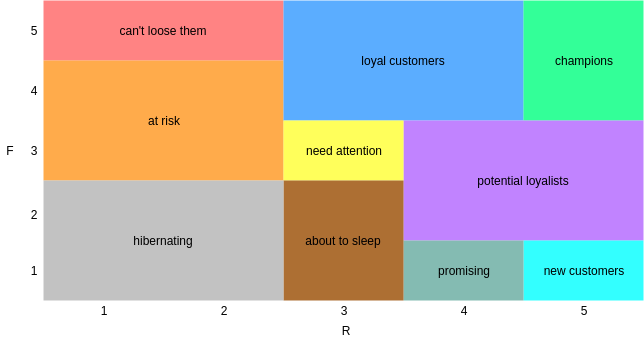

In [ ]:
#RFM 
rfm["RFM_Score"] =  (rfm["Recency_Score"].astype(str) + rfm["Frequency_Score"].astype(str))

In [ ]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm["Segment"] = rfm["RFM_Score"].replace(seg_map,regex = True)
rfm = rfm[["Recency", "Frequency", "Monetary", "RFM_Score","Segment"]]
rfm.head()

In [ ]:
segments_counts = rfm['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='orchid')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions']:
            bar.set_color('salmon')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left')
plt.show()

#### **Segmentlerin betimsel istatistiklerinin yorumlanması**


In [ ]:
rfm[["Segment", "Recency","Frequency","Monetary"]].groupby("Segment").agg(["mean","count","max"]).round()

**Champions**
* Bu segmentte 852 kişi bulunmaktadır.
* Ortalama 9 gün önce alışveriş yapılmıştır. 
* Alışveriş yapılma frekansı 19, toplam alışveriş sayısı  398'dir.
* Toplam 608.822 Sterlin harcama yapılmıştır. 

**Aksiyon**

 Bu segmentteki müşterileri detaylı analiz ederek kişiselleştirilmiş kampanyalar oluşturulabilir. 
 Böylece kendilerini özel hissedeceklerdir. Örneğin özel günlerde ürün hediyeleri, kampanyalar yapılabilir.Yeni ürünleri hediye ederek markanızı tanıtmanıza destek olabilirler

**Need Attention**
* Bu segmentte 270 kişi bulunmaktadır.
* Ortalama 114 gün önce alışveriş yapılmıştır. 
* Alışveriş yapılma frekansı 3, toplam alışveriş sayısı  4'dir.
* Toplam 39.916 Sterlin harcama yapılmıştır. 

**Aksiyon**

Bu müşterilere markamızı hatırlatmak ve tekrar satın alma yapmasını sağlamak için kısa süreli indirimler yapılabilir. 


**Can't Loose**
* Bu segmentte 71 kişi bulunmaktadır.
* Ortalama 332 gün önce alışveriş yapılmıştır. 
* Alışveriş yapılma frekansı 16, toplam alışveriş sayısı  155'dir.
* Toplam 77.556 Sterlin harcama yapılmıştır. 

**Aksiyon**

En son alışveriş 332 gün yapılmış olsa bile toplam alışveriş sayısı yüksektir.  Uzun süre gelmeyen ama geldiğinde de  fazla alışveriş yapan müşteri grubudur. Bu müşterilere anketler göndererek süreci analiz edilebilir, e-mail ile kişiye özel kampanyalar paylaşarak geri kazanılabiliriz. 